# A/B-тестирование интернет-магазина


**Описание проекта:**
Тестирование списка гипотез для увеличения выручки крупного интернет-магазина.

**Ход исследования:**
1. [Предобработка данных:](#eda)
    - импорт данных;
    - проверка на дубликаты;
    - проверка на аномалии.

2. [Приоритизация гипотез:](#hypothesis)
    - Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
    - Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
    - Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.
   
3. [Анализ A/B-теста:](#ab_test)
    - Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
    - Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
    - Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
    - Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
    - Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
    - Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
    - Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
    - Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
    - Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
    - Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
    - Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
    - Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
    - Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
    - Примите решение по результатам теста и объясните его. Варианты решений:
        1. Остановить тест, зафиксировать победу одной из групп.
        2. Остановить тест, зафиксировать отсутствие различий между группами.
        3. Продолжить тест.
        
1. [Выводы по исследованию](#summary)

**Описание данных**

В файле hypothesis.csv:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

В файле orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

В файле visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil
import scipy.stats as stats
import warnings

In [2]:
# Глабальные настройки по умолчинию для проекта

# игнорируем ненужные предупреждения
warnings.filterwarnings("ignore")

# применяем тему для графиков по умолчинию

# повысим качество изображения графиков
%config InlineBackend.figure_format='retina' 

# Настройки графиков
sns.set_theme(style='whitegrid', palette='Set2', rc={'figure.figsize':(12, 6)})

# отображение вещественных чисел
pd.set_option('display.float_format', lambda x: format(x, ',.2f').replace(',', '\xa0')) 

<a id="eda"></a>
   
## Предобработка данных

- импорт данных;
- проверка на дубликаты;
- проверка на аномалии.

In [3]:
# импорт данных
hypothesis = pd.read_csv("/datasets/hypothesis.csv")
visitors = pd.read_csv("/datasets/visitors.csv")
orders = pd.read_csv("/datasets/orders.csv")

In [4]:
# Создадим функцию, которая выводит необходимую информацию о датафрейме для ознакомления с данными

def get_df_info(df):
    sep = '-'
    repiat = 100
    df.info() # общая информация
    print(sep*repiat)
    display(df.head()) # первые пять строк
    display(df.tail()) # последние пять строк
    print(sep*repiat)
    print('Количество строк-дубликатов:', df.duplicated().sum()) # количество явных дулбикатов
    print(sep*repiat)
    print('Количество пропусков по столбцам')
    display(df.isna().sum()) # количество пропусков
    print(sep*repiat)
    display(df.describe(percentiles=[.25, .5, .75, .9, .95, .99], 
                        include=[np.number], datetime_is_numeric=True).T) # описание числовых полей
    display(df.describe(exclude=[np.number], datetime_is_numeric=False).T) # описание нечисловых полей
    print(sep*repiat)
    num_cols_count = ceil((df.dtypes != 'object').sum() / 2) 
    df.hist(figsize=(15, 5 * num_cols_count)); # гистограмма для числовых полей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
----------------------------------------------------------------------------------------------------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,Hypothesis,Reach,Impact,Confidence,Efforts
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


----------------------------------------------------------------------------------------------------
Количество строк-дубликатов: 0
----------------------------------------------------------------------------------------------------
Количество пропусков по столбцам


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Reach,9.00,4.78,3.15,1.00,3.00,3.00,8.00,8.40,9.20,9.84,10.00
Impact,9.00,4.78,3.19,1.00,3.00,3.00,7.00,9.20,9.60,9.92,10.00
Confidence,9.00,5.56,3.05,1.00,3.00,7.00,8.00,8.20,8.60,8.92,9.00
Efforts,9.00,4.89,2.80,1.00,3.00,5.00,6.00,8.40,9.20,9.84,10.00


,count,unique,top,freq
Hypothesis,9,9,Показать на главной странице баннеры с актуаль...,1


----------------------------------------------------------------------------------------------------


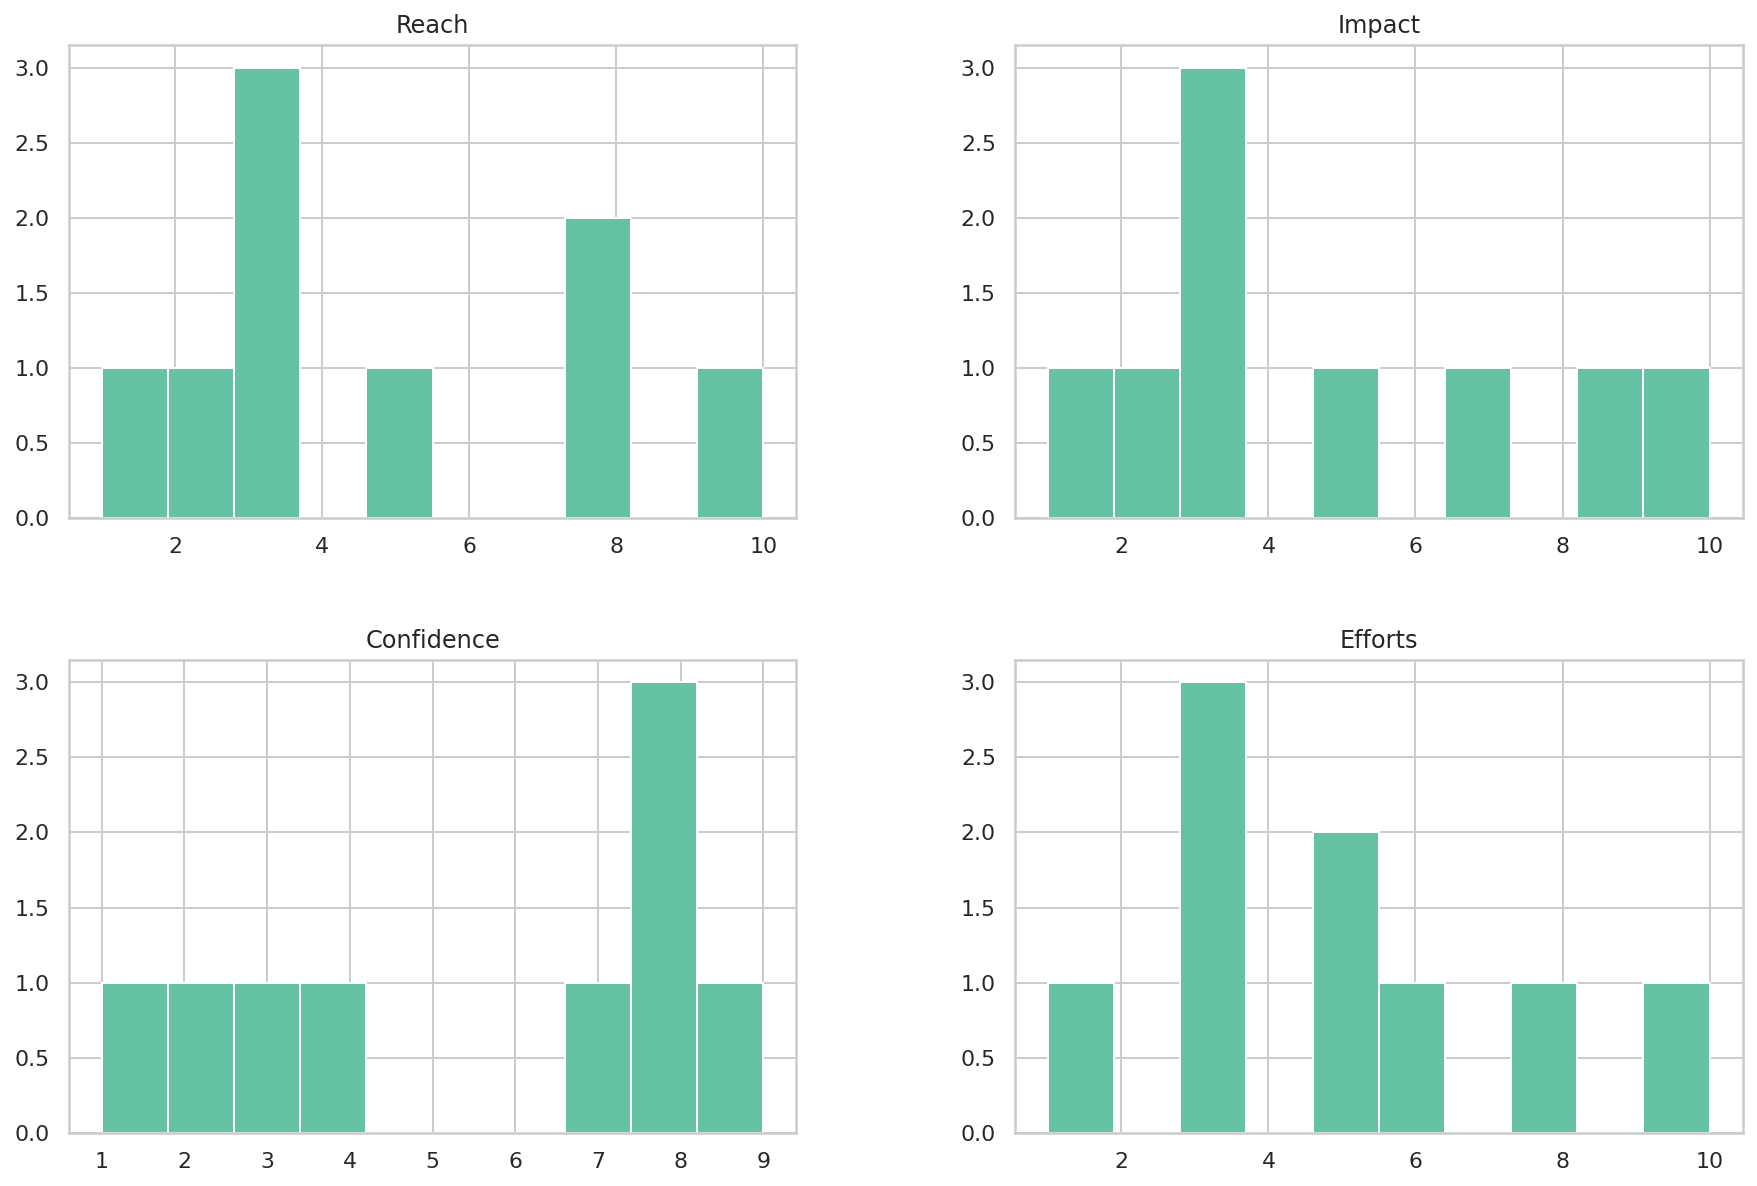

In [5]:
# ознакомимся с данными в датафрейме гипотезы
get_df_info(hypothesis)

Данные импортировались корректно. Датафрейм с гипотезами готов к работе, только приведем к змеинному регистру названия столбцов.

In [6]:
# приводим названия столбцов к змеиному регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
----------------------------------------------------------------------------------------------------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,date,group,visitors
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


----------------------------------------------------------------------------------------------------
Количество строк-дубликатов: 0
----------------------------------------------------------------------------------------------------
Количество пропусков по столбцам


date        0
group       0
visitors    0
dtype: int64

----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
visitors,62.00,607.29,114.40,361.00,534.00,624.50,710.50,733.70,747.90,769.39,770.00


,count,unique,top,freq
date,62,31,2019-08-19,2
group,62,2,B,31


----------------------------------------------------------------------------------------------------


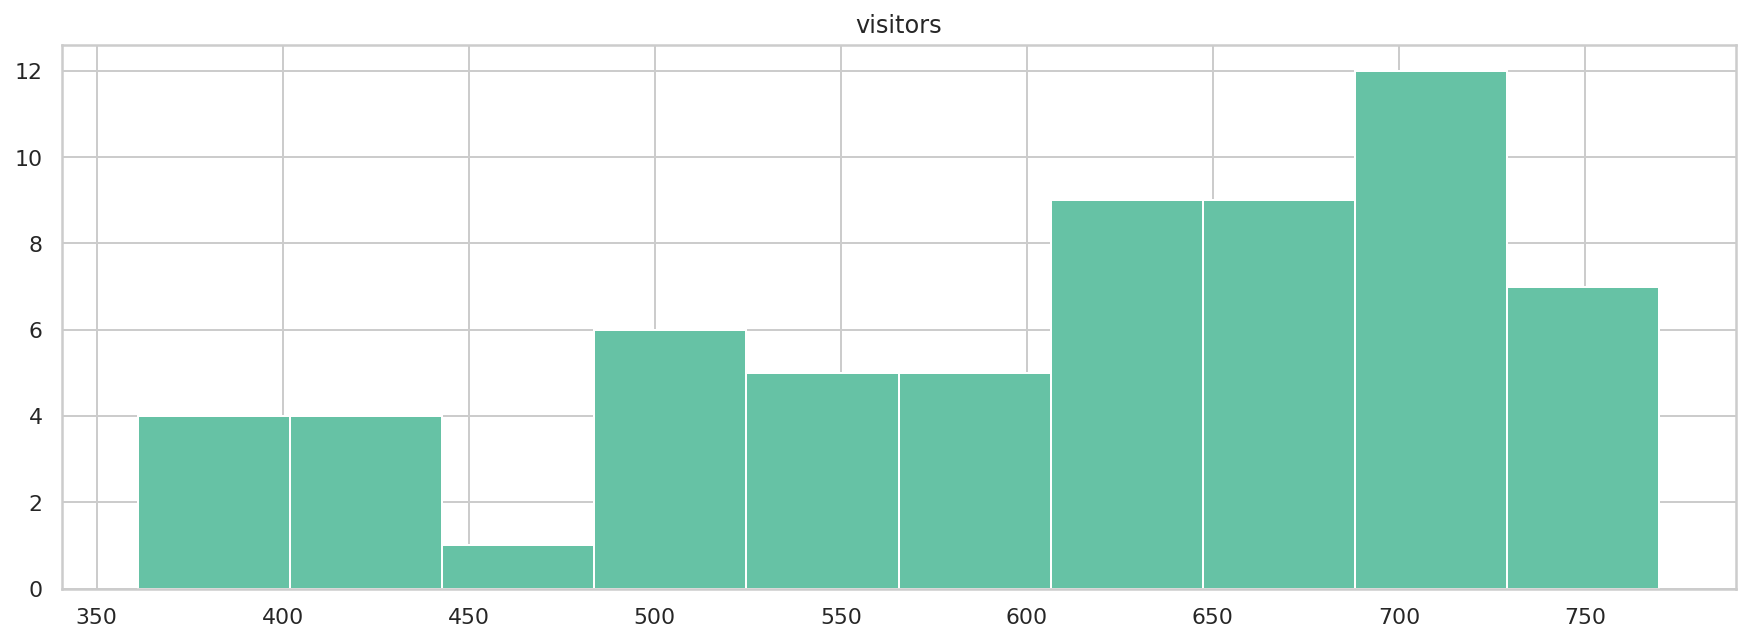

In [7]:
# ознакомимся с данными в датафрейме посетители
get_df_info(visitors)

Датафрейм посетители тоже готов к анализу. Приведем лишь тип данных в столбце дата и группа к соответствующим.

In [8]:
# приводим столбцы к соответствующим типам данных
visitors.date = visitors.date.astype('datetime64')
visitors.group = visitors.group.astype('category')
visitors.dtypes

date        datetime64[ns]
group             category
visitors             int64
dtype: object

In [9]:
# проверим столбец с датами
visitors.date.describe()

count                      62
unique                     31
top       2019-08-27 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Данные по посетителям за август 2019.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
----------------------------------------------------------------------------------------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,transactionId,visitorId,date,revenue,group
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A
1196,3936777065,2108080724,2019-08-15,202740,B


----------------------------------------------------------------------------------------------------
Количество строк-дубликатов: 0
----------------------------------------------------------------------------------------------------
Количество пропусков по столбцам


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
transactionId,1 197.00,2 155 621 385.53,1 229 084 904.76,1 062 393.00,1 166 775 572.00,2 145 193 898.00,3 237 740 112.00,3 832 582 238.40,4 067 471 456.20,4 239 148 157.32,4 293 855 558.00
visitorId,1 197.00,2 165 960 143.10,1 236 014 192.15,5 114 589.00,1 111 826 046.00,2 217 984 702.00,3 177 606 451.00,3 909 872 223.80,4 080 749 199.80,4 256 040 402.00,4 283 872 382.00
revenue,1 197.00,8 348.01,39 191.13,50.00,1 220.00,2 978.00,8 290.00,18 168.00,28 000.00,58 233.20,1 294 500.00


,count,unique,top,freq
date,1197,31,2019-08-05,48
group,1197,2,B,640


----------------------------------------------------------------------------------------------------


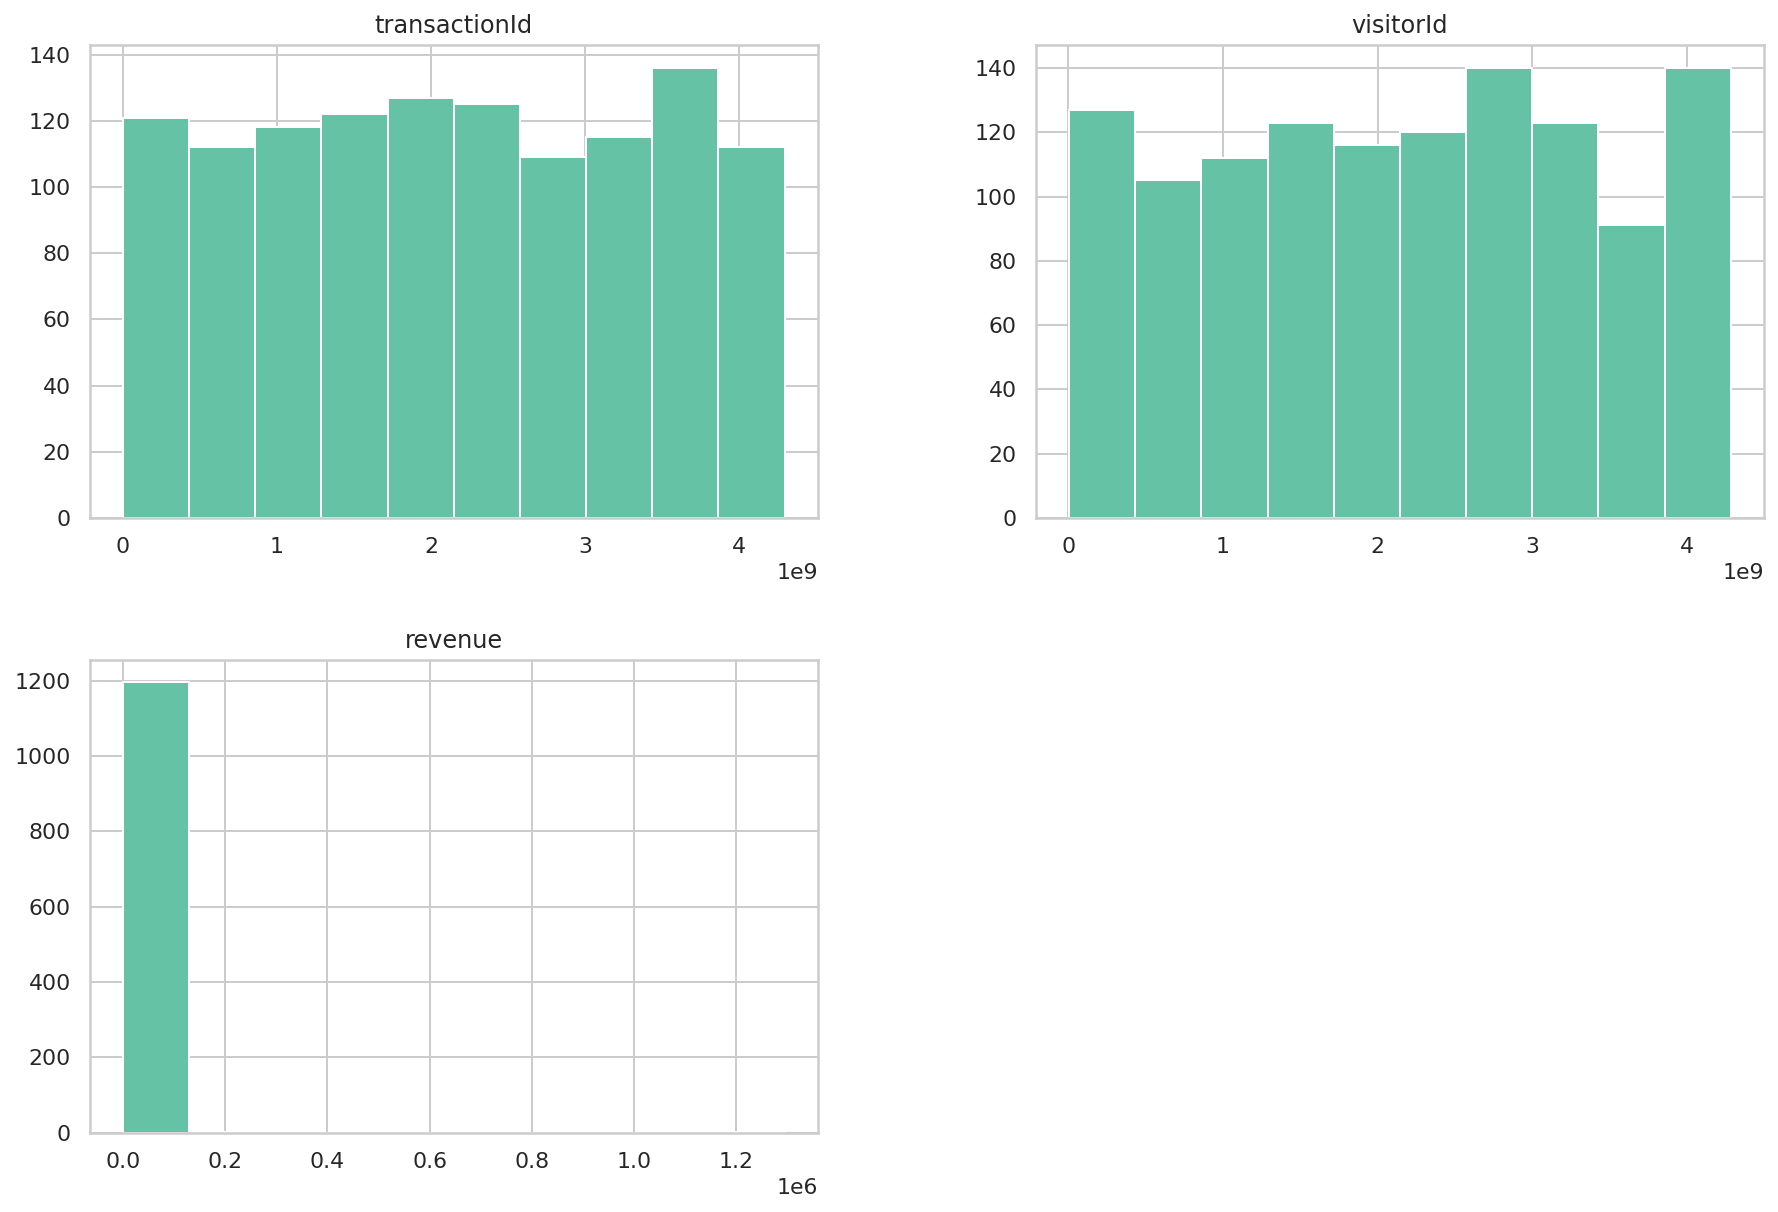

In [10]:
# ознакомимся с данными в датафрейме заказы
get_df_info(orders)

В данных по заказам есть выбросы в столбце выручка. Изучим подробнее их в разделе Анализ А/B-теста. Сейчас только поправим названия столбцов и тип данных.

In [11]:
# приводим столбцы к соответствующим типам данных
orders.date = orders.date.astype('datetime64')
orders.group = orders.group.astype('category')
orders.dtypes

transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                  category
dtype: object

In [12]:
# приводим названия столбцов к змеинному регистру
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [13]:
# проверим столбец с датами
orders.date.describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Данные по заказам за август 2019.

In [37]:
# проверим, сколько пользователей попали в обе группы
(orders.groupby('visitor_id').agg({'group':'nunique'}) > 1).mean()

group   0.06
dtype: float64

In [14]:
# Проверим соотношение групп
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

В группе В больше 200 наблюдений, однако с учетом того, что в каждой группе более 18 тыс. посетителей, данную разницу не будем считать значимой.

**Выводы:**
- существенных различий по количеству наблюдений между группами нет,
- привели данные нужному типу,
- переименовали столбцы согласно змеинному регистру.

<a id="hypothesis"></a>

## Приоритизация гипотез

- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [15]:
# Примените фреймворк ICE для приоритизации гипотез
hypothesis['ice'] = hypothesis.impact * hypothesis.confidence / hypothesis.efforts

# Отсортируйте их по убыванию приоритета
with pd.option_context('display.max_colwidth', None):
    display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


На основе оценки ICE в первую очередь нужно проверить гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

In [16]:
# Примените фреймворк RICE для приоритизации гипотез. 
hypothesis['rice'] = hypothesis.reach * hypothesis.impact * hypothesis.confidence / hypothesis.efforts

# Отсортируйте их по убыванию приоритета.
with pd.option_context('display.max_colwidth', None):
    display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Список топ 3 изменился. На основе оценки RICE в первую очередь нужно проверить гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

In [17]:
# приоритизация гипотез при применении RICE и ICE
with pd.option_context('display.max_colwidth', None):
    display(hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by=['ice', 'rice'], ascending=False))

,hypothesis,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


**Вывод:** в ICE учитываются такие оценки, как влияние, уверенность и усилия. В RICE к ним добавляется также охват аудитории, что существенно меняет приоритизацию гипотез. Так гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" имеет широкий охват аудитории и как следтсвие самый высокий приоритет по оценке RICE, тогда как по оценке ICE - третья по очереди. Напротив гипотеза "Запустить акцию, дающую скидку на товар в день рождения" имеет необольшой охват (низкий приоритет по RICE), хотя может иметь существенное влияние на покупательское поведение отдельного пользователя (самый высокий приоритет по ICE).

<a id="ab_test"></a>

## Анализ A/B-теста

- Аккумулятивные метрики
    - Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
    - Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
    - Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
    - Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
    - Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
    
    
- Определение значения порога для выбросов
    - Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
    - Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
    - Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
    - Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.


- Проверка гипотез
    - Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
    - Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
    - Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
    - Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.


- Примите решение по результатам теста и объясните его. Варианты решений:
    1. Остановить тест, зафиксировать победу одной из групп.
    2. Остановить тест, зафиксировать отсутствие различий между группами.
    3. Продолжить тест.

### Аккумулятивные метрики

In [18]:
# аккумулятивный расчет просмотров по группам
# группируем по дате и группе А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# аккумулятивный расчет просмотров по группе А 
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

# группируем по дате и группе В
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

# аккумулятивный расчет просмотров по группе В
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

# аккумулятивный расчет заказов по группам
# группируем по дате и группе A
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# аккумулятивный расчет заказов по группе А
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

# группируем по дате и группе В
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# аккумулятивный расчет заказов по группе B
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

# объединяем в один датафрейм 
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


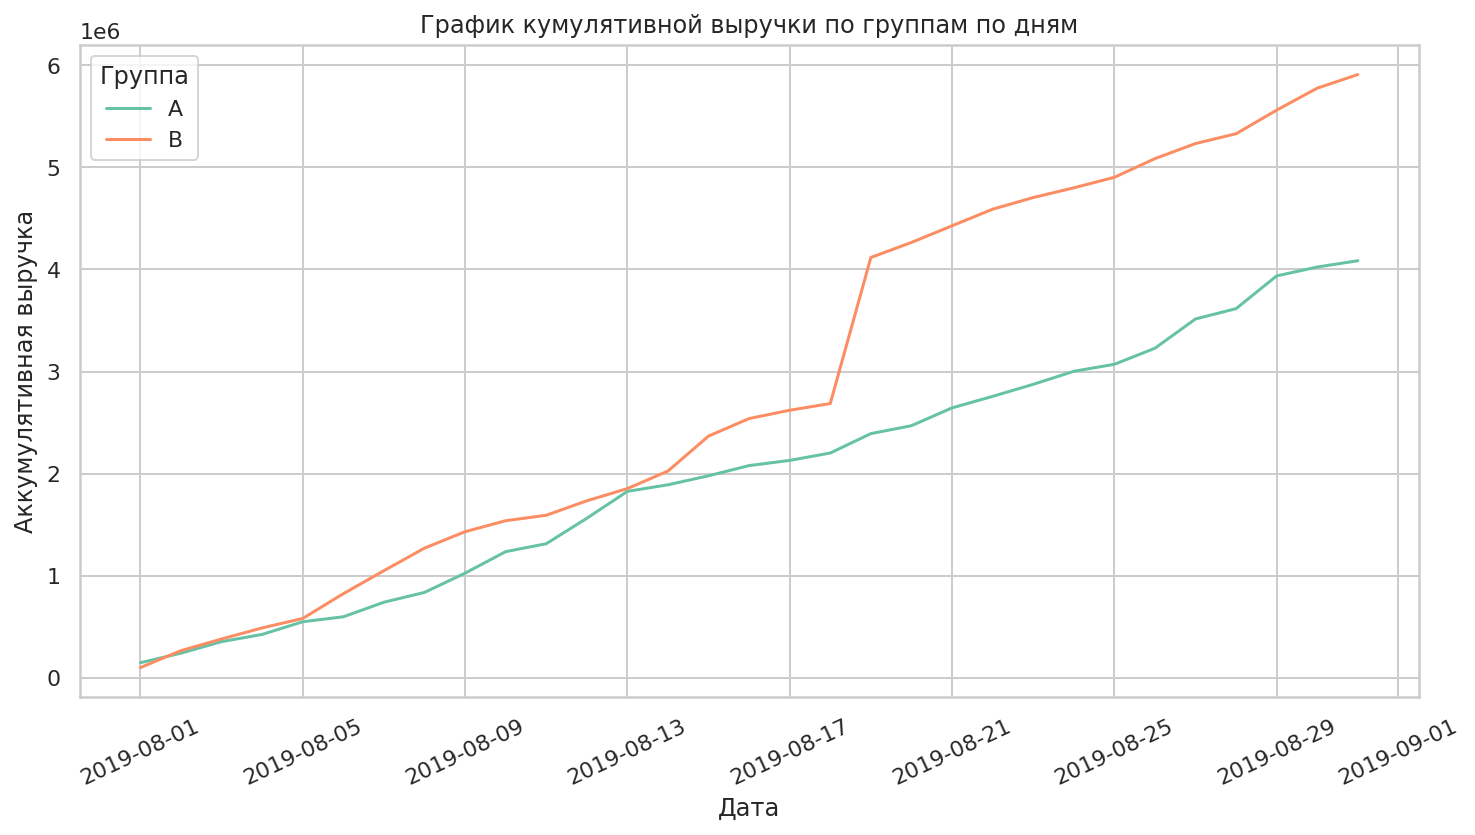

In [19]:
# Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
sns.lineplot(data=data, y='revenue_cummulative_a', x='date', label='A')
sns.lineplot(data=data, y='revenue_cummulative_b', x='date', label='B')
plt.title('График кумулятивной выручки по группам по дням')
plt.ylabel('Аккумулятивная выручка')
plt.xlabel('Дата')
plt.xticks(rotation=25)
plt.legend(title='Группа')
plt.show()

Выручка в обеих группах растет паралелльно. Однако в группе В есть выбросы 19 августа, из-за чего график аккумулятивной вырочки резко вырос.

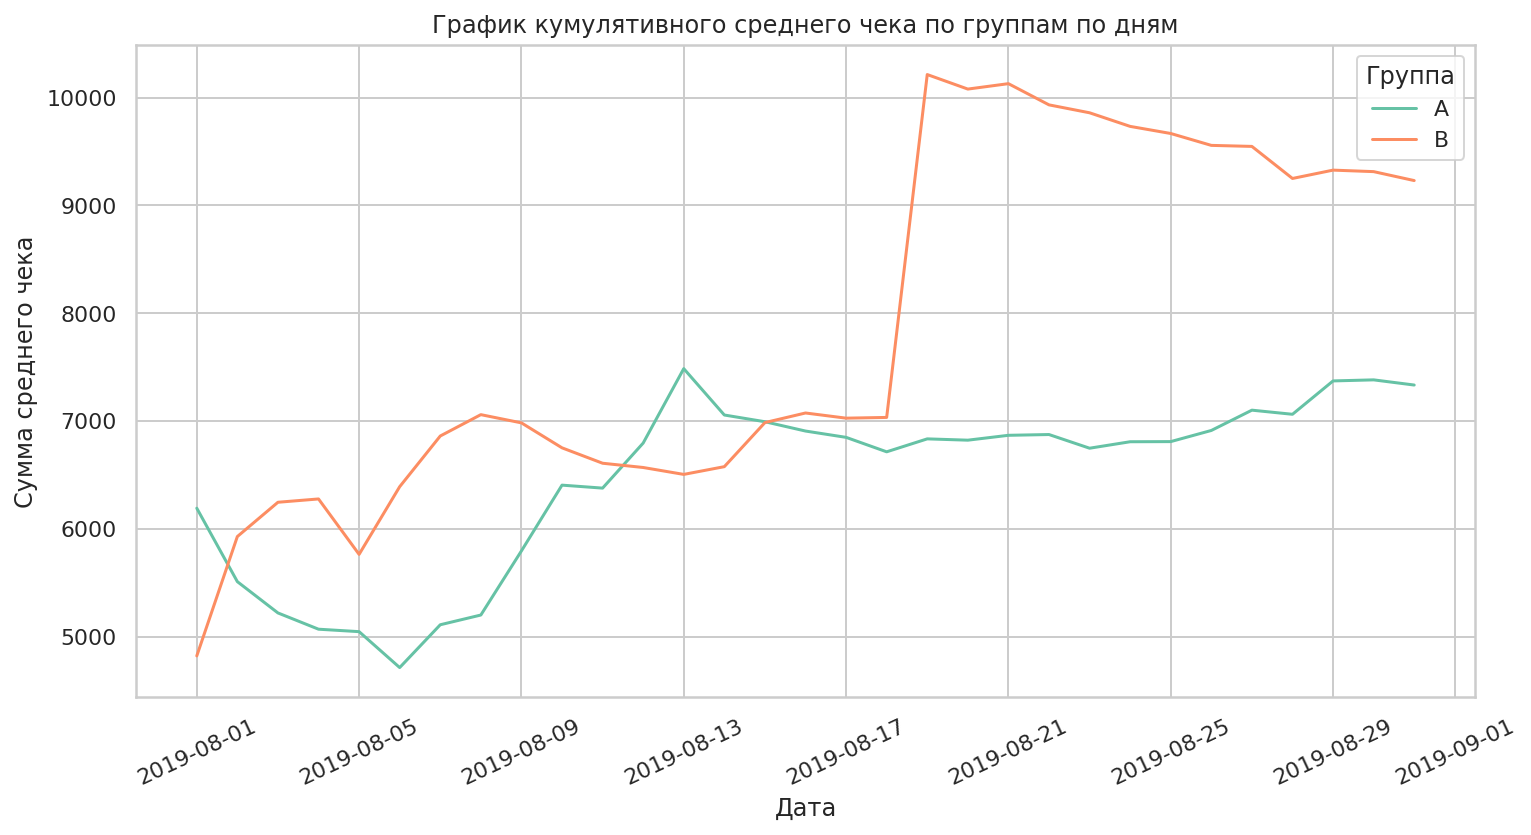

In [20]:
# Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

plt.plot(data.date, data.revenue_cummulative_a / data.orders_cummulative_a, label='A')
plt.plot(data.date, data.revenue_cummulative_b / data.orders_cummulative_b, label='B')
plt.title('График кумулятивного среднего чека по группам по дням')
plt.ylabel('Сумма среднего чека')
plt.xlabel('Дата')
plt.xticks(rotation=25)
plt.legend(title='Группа')
plt.show()

По графику можно сделать вывод, что в группе А в первую неделю было много бюджетных заказов. На третью неделю средний чек по группам приходит к стабильному показателю, но из-за выбросов 19 августа в группе В, который был виден еще на предыдущем графике, наблюдаем сильно смещение вверх. Со временем данный скачок графика сглаживается. Ожидаемая сумма среднего чека ожидается в диапозоне 7000-8000.

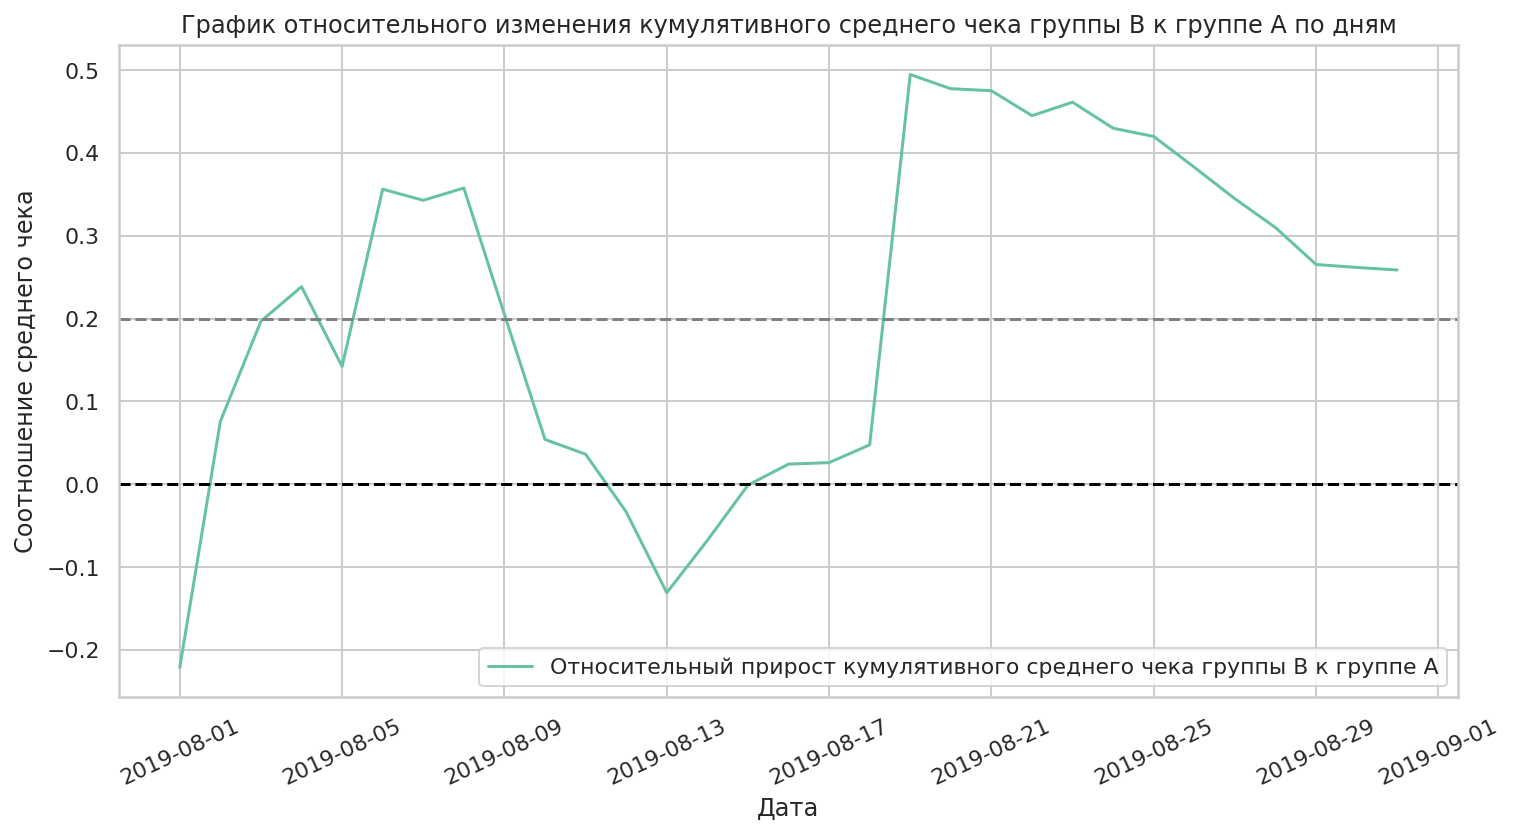

In [21]:
# Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. 
# Сделайте выводы и предположения.

plt.plot(data.date, 
         ((data.revenue_cummulative_b / data.orders_cummulative_b) 
          / (data.revenue_cummulative_a / data.orders_cummulative_a) 
          - 1), 
         label='Относительный прирост кумулятивного среднего чека группы B к группе A')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A по дням')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.ylabel('Соотношение среднего чека')
plt.xlabel('Дата')
plt.xticks(rotation=25)  
plt.legend()
plt.show()

Можно сделать вывод, что группа В лучше по среднему чеку на 25% чем группа А. Стоит отметить, что график соотношения среднего чека между группами на протяжении всего месяца крайне не равномерный - диапозон значений от - 0,15 до 0,5.

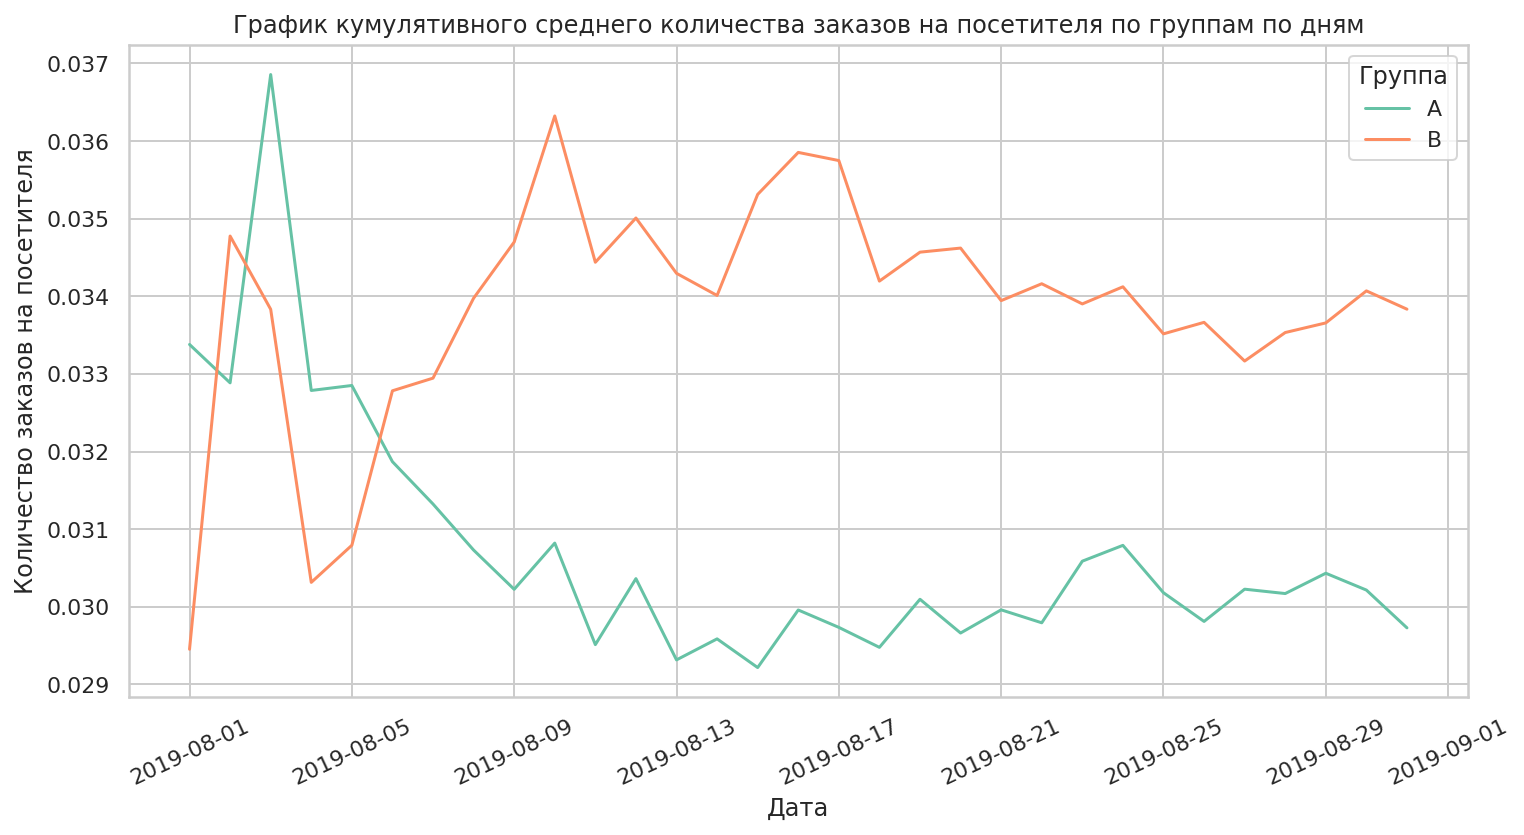

In [22]:
# Постройте график кумулятивного среднего количества заказов на посетителя по группам. 
# Сделайте выводы и предположения.

plt.plot(data.date, data.orders_cummulative_a / data.visitors_cummulative_a, label='A')
plt.plot(data.date, data.orders_cummulative_b / data.visitors_cummulative_b, label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам по дням')
plt.ylabel('Количество заказов на посетителя')
plt.xlabel('Дата')
plt.xticks(rotation=25)  
plt.legend(title='Группа')
plt.show()

Больше заказов на пользователя в группе В - в среднем 0,034, тогда как в группе А - в среднем 0,03.

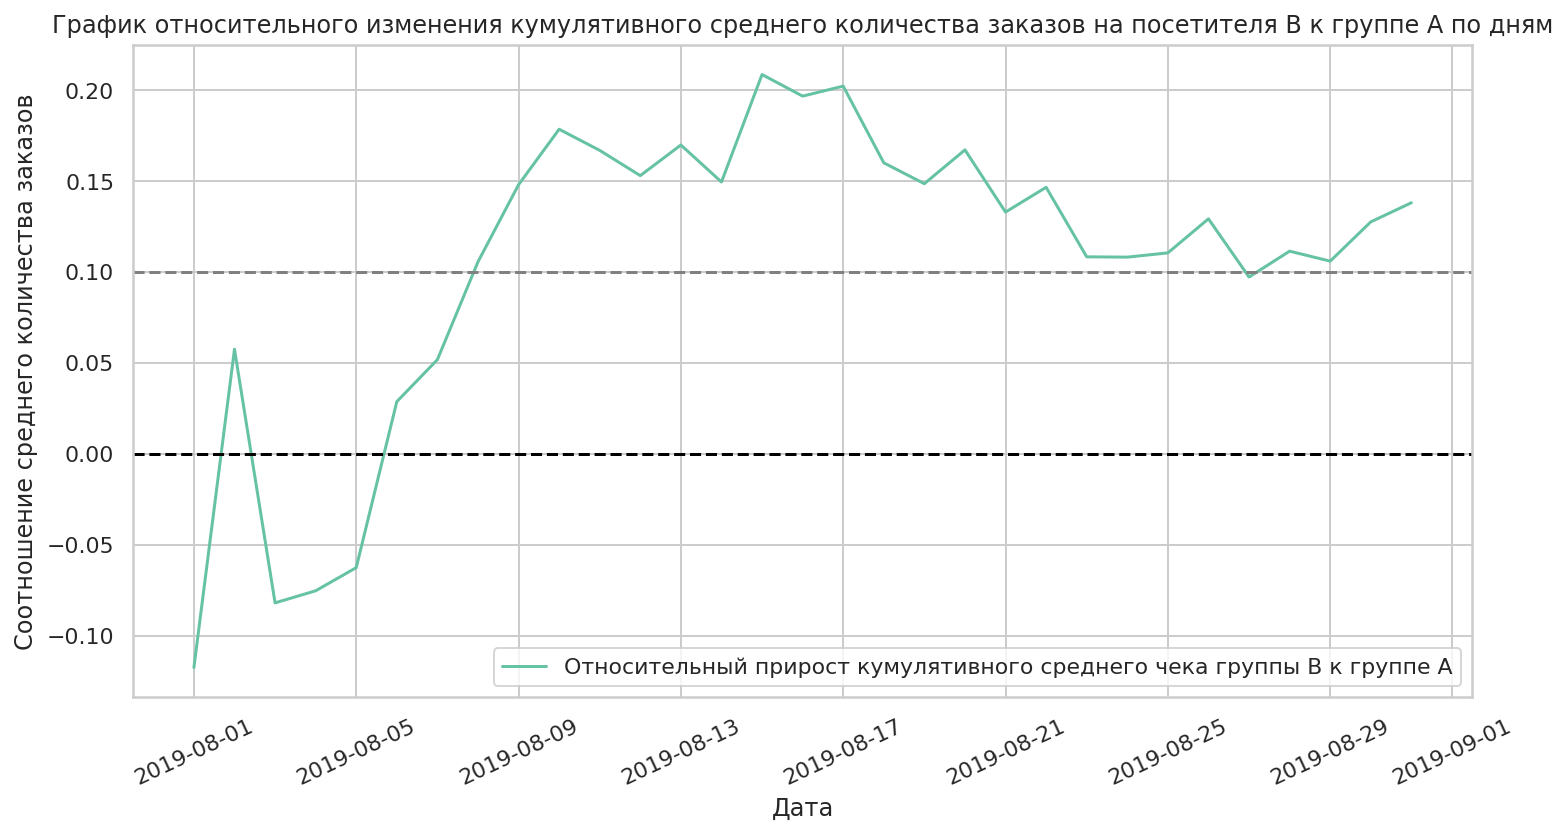

In [23]:
# Постройте график относительного изменения кумулятивного среднего количества 
# заказов на посетителя группы B к группе A. 
# Сделайте выводы и предположения.

plt.plot(data.date, 
         ((data.orders_cummulative_b / data.visitors_cummulative_b) 
          / (data.orders_cummulative_a / data.visitors_cummulative_a) 
          - 1), 
         label='Относительный прирост кумулятивного среднего чека группы B к группе A')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя B к группе A по дням')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.ylabel('Соотношение среднего количества заказов')
plt.xlabel('Дата')
plt.xticks(rotation=25)  
plt.legend()
plt.show()

Группа В лучше на 10% по среднему количеству заказов на пользователя чем группа А.

**Выводы:**
- Выручка в обеих группах растет паралелльно. Однако в группе В есть выбросы 19 августа, из-за чего график аккумулятивной вырочки резко вырос.
- В группе А в первую неделю было много бюджетных заказов. На третью неделю средний чек по группам приходит к стабильному показателю, но из-за выбросов 19 августа в группе В наблюдаем сильно смещение вверх. Со временем данный скачок графика сглаживается. Ожидаемая сумма среднего чека ожидается в диапозоне 7000-8000.
- Группа В лучше по среднему чеку на 25% чем группа А.
- Больше заказов на пользователя в группе В - в среднем 0,034, тогда как в группе А - в среднем 0,03.
- Группа В лучше на 10% по среднему количеству заказов на пользователя чем группа А.

### Определение значения порога для выбросов

In [24]:
# Подсчитаем количество заказов по посетителям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


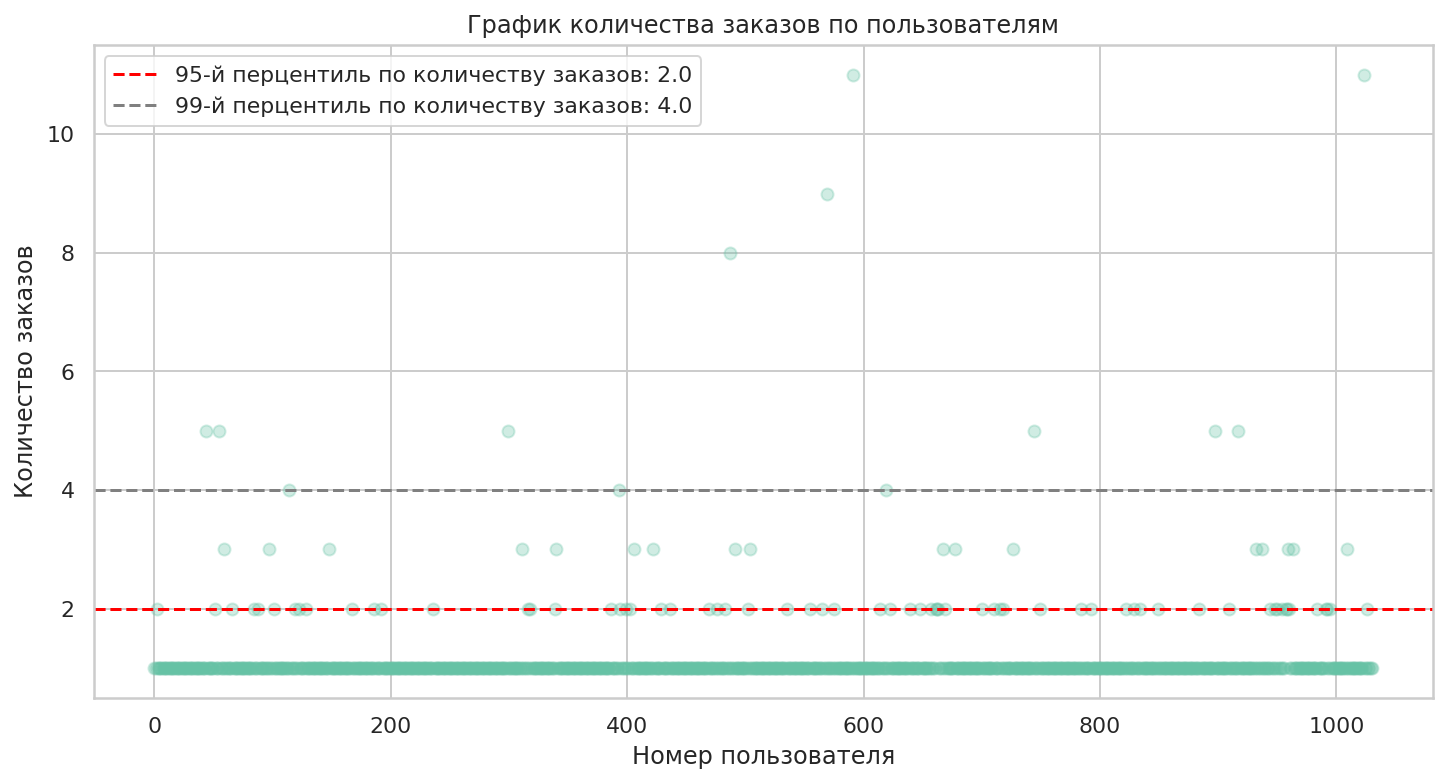

In [25]:
# Постройте точечный график количества заказов по пользователям. 
# Сделайте выводы и предположения.
plt.scatter(orders_by_users.index, orders_by_users.orders, alpha=.3)
plt.title('График количества заказов по пользователям')
plt.axhline(y=np.percentile(orders_by_users.orders, 95), 
            color='r', linestyle='--', 
            label=f'95-й перцентиль по количеству заказов: {np.percentile(orders_by_users.orders, 95)}')
plt.axhline(y=np.percentile(orders_by_users.orders, 99), 
            color='gray', linestyle='--', 
            label=f'99-й перцентиль по количеству заказов: {np.percentile(orders_by_users.orders, 99)}')
plt.ylabel('Количество заказов')
plt.xlabel('Номер пользователя') 
plt.legend()
plt.show()

Абсолютное большинство пользователей совершили один заказ, 5% пользователей сделали 2 и более заказов, 1% пользователей - 4 и более заказов.

In [26]:
# Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. 
# Выберите границу для определения аномальных пользователей.

np.percentile(orders_by_users.orders, [25, 50, 75, 90, 95, 99])

array([1., 1., 1., 1., 2., 4.])

4 и более заказов на пользователя довольно редкое количество, которое составляют не более 1% данных о заказах. Поэтому отфильтруем данные по 99-му перцентилю.

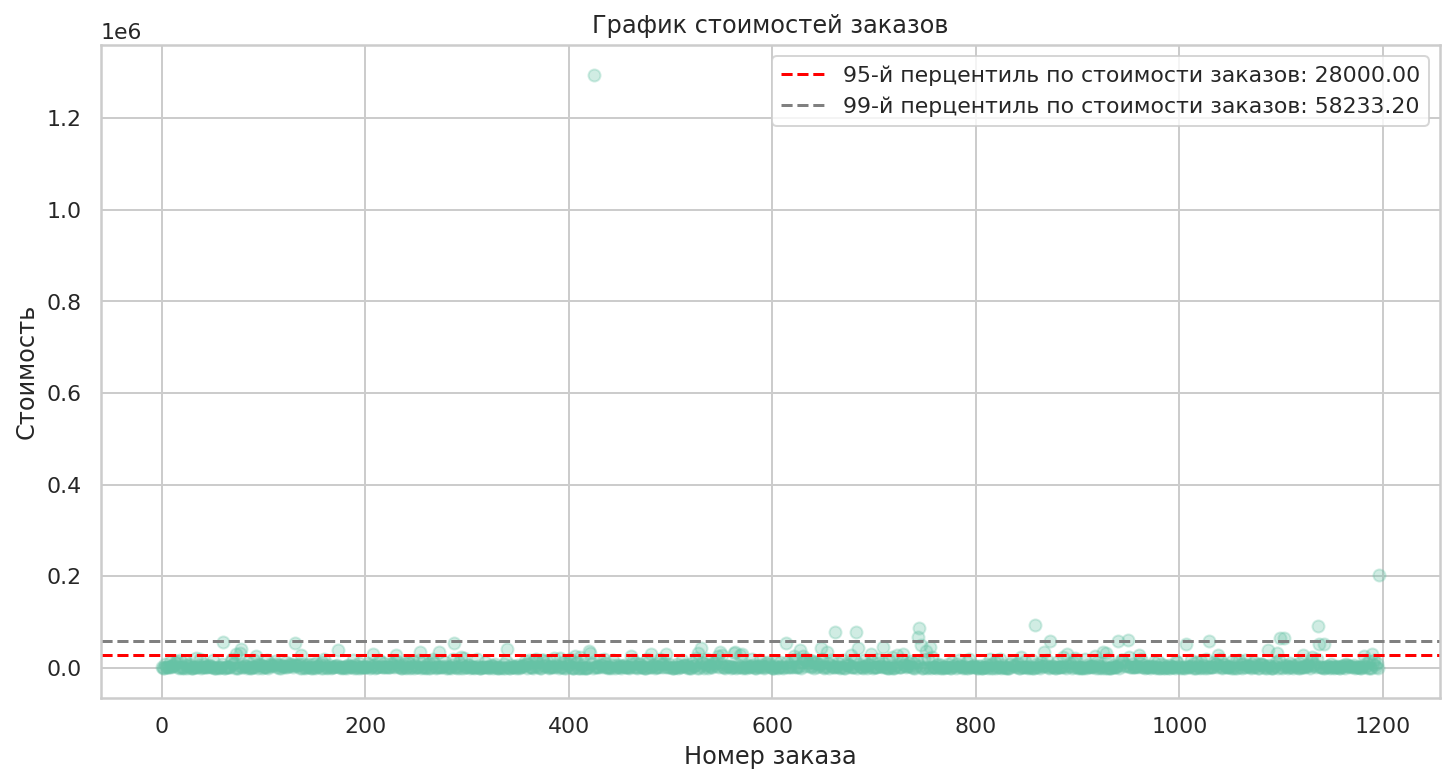

In [27]:
# Постройте точечный график стоимостей заказов. 
# Сделайте выводы и предположения.
plt.scatter(orders.index, orders.revenue, alpha=.3)
plt.title('График стоимостей заказов')
plt.axhline(y=np.percentile(orders.revenue, 95), 
            color='r', linestyle='--', 
            label=f'95-й перцентиль по стоимости заказов: {np.percentile(orders.revenue, 95):.2f}')
plt.axhline(y=np.percentile(orders.revenue, 99), 
            color='gray', linestyle='--', 
            label=f'99-й перцентиль по стоимости заказов: {np.percentile(orders.revenue, 99):.2f}')
plt.ylabel('Стоимость')
plt.xlabel('Номер заказа')
plt.legend()
plt.show()

95% заказов имеют чек до 28 тыс. Для 1% заказов стоимость составила 58,2 тыс. В данных также есть выброс - 1,3 млн., который сильно влияет на показатели метрик и результаты тестирования.

In [28]:
# Посчитайте 95-й и 99-й перцентили стоимости заказов. 
# Выберите границу для определения аномальных заказов.
np.percentile(orders.revenue, [25, 50, 75, 90, 95, 99])

array([ 1220. ,  2978. ,  8290. , 18168. , 28000. , 58233.2])

58,2 тыс. и более по сумме заказа довольно редки и составляют не более 1% данных о заказах. Поэтому отфильтруем данные по 99-му перцентилю. Таким образом при фильровании данных будет отсечено не более 10% наблюдений.

In [29]:
# Фильтруем выбросы в заказах: по стоимости и количеству
filtered_orders = orders[orders['visitor_id'].isin(orders_by_users[orders_by_users['orders'] < 4]['visitor_id']) 
                         & (orders['revenue'] < 58233.2)]

# Подсчитаем долю отфильтрованных заказов
(orders.shape[0] - filtered_orders.shape[0]) / orders.shape[0]

0.07769423558897243

**Выводы:**
- Абсолютное большинство пользователей совершили один заказ, 5% пользователей сделали 2 и более заказов, 1% пользователей - 4 и более заказов. Поэтому отфильтровали данные по 99-му перцентилю - более 4 заказов.
- 95% заказов имеют чек до 28 тыс. Для 1% заказов стоимость составила 58,2 тыс. В данных также есть выброс - 1,3 млн., который сильно влияет на показатели метрик и результаты тестирования. Поэтому отфильтровали данные по 99-му перцентилю - более 58,2 тыс. 
- При фильровании данных было отсечено не более 7,8% наблюдений.

### Проверка гипотез

Исследуем среднее количество заказов на посетителя между группами. Проверим гипотезы методом Манна-Уитни:
- нулевая гипотеза: среднее количество заказов на посетителя группы B к группе A не различаются;
- альтернативная гипотеза: среднее количество заказов на посетителя группы B к группе A различаются.

In [30]:
# Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя 
# между группами по «сырым» данным. Сделайте выводы и предположения.

# подсчитаем кол-во пользователей, сделавших заказ
orders_by_users_a = (
    orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

# добавим пользователей, несделавших заказ
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(
                      data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

# подсчитаем кол-во пользователей, сделавших заказ
orders_by_users_b = (
    orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b.columns = ['visitor_id', 'orders']
# добавим пользователей, несделавших заказ
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(
                      data['visitors_per_date_a'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

# уровень статистической значимости
alpha = 0.05
t_stat, p_val = stats.mannwhitneyu(sample_a, sample_b)

print('Отношение среднего количества заказов на посетителей группы B к группе A:', 
      '{0:.3f}'.format(sample_b.mean()/sample_a.mean()-1))

print(f"Гипотеза 1: t-статистика = {t_stat:.2f}, p-значение = {p_val:.2f}")

if p_val < alpha:
    print("Гипотеза 1: Отклоняем нулевую гипотезу, среднее количество заказов на посетителя группы B к группе A различаются.")
else:
    print("Гипотеза 1: Не отклоняем нулевую гипотезу, среднее количество заказов на посетителя группы B к группе A не различаются.")

Отношение среднего количества заказов на посетителей группы B к группе A: 0.149
Гипотеза 1: t-статистика = 174741596.00, p-значение = 0.01
Гипотеза 1: Отклоняем нулевую гипотезу, среднее количество заказов на посетителя группы B к группе A различаются.


В результате проверки гипотезы с помощью метода Манна-Уитни отклоняем нулевую гипотезу и на уровне p-значения 0,05. Отношение среднего количества заказов на посетителей группы B к группе A 14,9%.

Исследуем средний чек заказа между группами. Проверим гипотезы также методом Манна-Уитни:
- нулевая гипотеза: средний чек заказа группы B к группе A не различаются;
- альтернативная гипотеза: средний чек заказа группы B к группе A различаются.

In [31]:
# Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
# Сделайте выводы и предположения.

# подсчитаем кол-во пользователей, сделавших заказ
revenue_a = orders[orders['group'] == 'A']['revenue']
# добавим пользователей, несделавших заказ
sample_a = pd.concat([revenue_a, pd.Series(0, index=np.arange(
                      data['visitors_per_date_a'].sum() - len(revenue_a)), name='revenue')], axis=0)

# подсчитаем кол-во пользователей, сделавших заказ
revenue_b = orders[orders['group'] == 'B']['revenue']
# добавим пользователей, несделавших заказ
sample_b = pd.concat([revenue_b, pd.Series(0, index=np.arange(
                      data['visitors_per_date_b'].sum() - len(revenue_b)), name='revenue')], axis=0)

# уровень статистической значимости
alpha = 0.05
t_stat, p_val = stats.mannwhitneyu(sample_a, sample_b)

print('Отношение среднего чека заказа группы B к группе A:', 
      '{0:.3f}'.format(sample_b.mean()/sample_a.mean()-1))

print(f"Гипотеза 1: t-статистика = {t_stat:.2f}, p-значение = {p_val:.2f}")

if p_val < alpha:
    print("Гипотеза 1: Отклоняем нулевую гипотезу, средний чек заказа группы B к группе A различаются.")
else:
    print("Гипотеза 1: Не отклоняем нулевую гипотезу, средний чек заказа группы B к группе A не различаются.")

Отношение среднего чека заказа группы B к группе A: 0.433
Гипотеза 1: t-статистика = 176475609.00, p-значение = 0.02
Гипотеза 1: Отклоняем нулевую гипотезу, средний чек заказа группы B к группе A различаются.


На основе проверки гипотезы методом Манна-Уитни отклоняем нулевую гипотезу на уровне значимости 0,05. Отношение среднего чека заказа группы B к группе A 43,3%.

In [32]:
# Посчитайте статистическую значимость различий в среднем количестве заказов 
# на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

# подсчитаем кол-во пользователей, сделавших заказ
orders_by_users_a = (
    filtered_orders[filtered_orders['group'] == 'A'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a.columns = ['visitor_id', 'orders']
# добавим пользователей, несделавших заказ
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(
                      data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)
# подсчитаем кол-во пользователей, сделавших заказ
orders_by_users_b = (
    filtered_orders[filtered_orders['group'] == 'B'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b.columns = ['visitor_id', 'orders']
# добавим пользователей, несделавших заказ
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(
                      data['visitors_per_date_a'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

# уровень статистической значимости
alpha = 0.05
t_stat, p_val = stats.mannwhitneyu(sample_a, sample_b)

print('Отношение среднего количества заказов на посетителей группы B к группе A:', 
      '{0:.3f}'.format(sample_b.mean()/sample_a.mean()-1))

print(f"Гипотеза 1: t-статистика = {t_stat:.2f}, p-значение = {p_val:.2f}")

if p_val < alpha:
    print("Гипотеза 1: Отклоняем нулевую гипотезу, среднее количество заказов на посетителя группы B к группе A различаются.")
else:
    print("Гипотеза 1: Не отклоняем нулевую гипотезу, среднее количество заказов на посетителя группы B к группе A не различаются.")

Отношение среднего количества заказов на посетителей группы B к группе A: 0.165
Гипотеза 1: t-статистика = 174723058.00, p-значение = 0.01
Гипотеза 1: Отклоняем нулевую гипотезу, среднее количество заказов на посетителя группы B к группе A различаются.


В отфильтрованном датасете также потверждаются различия между группами на уровне p-значения 0,05.
Стоит отметить, что отношение среднего количества заказов на посетителей группы B к группе A увеличилось и составило 16,5%.

In [33]:
# Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
# Сделайте выводы и предположения.

# подсчитаем кол-во пользователей, сделавших заказ
revenue_a = filtered_orders[filtered_orders['group'] == 'A']['revenue']
# добавим пользователей, несделавших заказ
sample_a = pd.concat([revenue_a, pd.Series(0, index=np.arange(
                      data['visitors_per_date_a'].sum() - len(revenue_a)), name='revenue')], axis=0)

# подсчитаем кол-во пользователей, сделавших заказ
revenue_b = filtered_orders[filtered_orders['group'] == 'B']['revenue']
# добавим пользователей, несделавших заказ
sample_b = pd.concat([revenue_b, pd.Series(0, index=np.arange(
                      data['visitors_per_date_b'].sum() - len(revenue_b)), name='revenue')], axis=0)

# уровень статистической значимости
alpha = 0.05
t_stat, p_val = stats.mannwhitneyu(sample_a, sample_b)

print('Отношение среднего чека заказа группы B к группе A:', 
      '{0:.3f}'.format(sample_b.mean()/sample_a.mean()-1))

print(f"Гипотеза 1: t-статистика = {t_stat:.2f}, p-значение = {p_val:.2f}")

if p_val < alpha:
    print("Гипотеза 1: Отклоняем нулевую гипотезу, средний чек заказа группы B к группе A различаются.")
else:
    print("Гипотеза 1: Не отклоняем нулевую гипотезу, средний чек заказа группы B к группе A не различаются.")

Отношение среднего чека заказа группы B к группе A: 0.130
Гипотеза 1: t-статистика = 176464871.50, p-значение = 0.02
Гипотеза 1: Отклоняем нулевую гипотезу, средний чек заказа группы B к группе A различаются.


В отфильтрованном датасете заказов на основе проверки гипотезы методом Манна-Уитни отклоняем нулевую гипотезу на уровне значимости 0,05. Отношение среднего чека заказа группы B к группе A снизилась и равняется 13%. Выбросы сильно повлияли на соотношение даже в ранговом методе.

In [34]:
# Создаем по группам выборки
revenue_a = filtered_orders[filtered_orders['group'] == 'A'][['date', 'revenue']]
df_a = visitors[visitors['group'] == 'A'][['date', 'visitors']].set_index('date')
df_a['visitors'] = df_a['visitors'] - revenue_a.groupby('date').agg({'revenue':'count'})['revenue']
df_a = df_a.reset_index()
unrevenue_a = pd.DataFrame(data=[[df_a.loc[0, 'date'], 0]]*df_a.loc[0, 'visitors'], 
                               columns=['date', 'revenue'])

for i in range(1, len(df_a)):
    unrevenue_a = pd.concat([unrevenue_a, pd.DataFrame(data=[[df_a.loc[i, 'date'], 0]]*df_a.loc[i, 'visitors'], 
                               columns=['date', 'revenue'])])
    
p_sample_a = pd.concat([revenue_a, unrevenue_a])


revenue_b = filtered_orders[filtered_orders['group'] == 'B'][['date', 'revenue']]
df_b = visitors[visitors['group'] == 'B'][['date', 'visitors']].set_index('date')
df_b['visitors'] = df_b['visitors'] - revenue_b.groupby('date').agg({'revenue':'count'})['revenue']
df_b = df_b.reset_index()
unrevenue_b = pd.DataFrame(data=[[df_b.loc[0, 'date'], 0]]*df_b.loc[0, 'visitors'], 
                               columns=['date', 'revenue'])

for i in range(1, len(df_b)):
    unrevenue_b = pd.concat([unrevenue_b, pd.DataFrame(data=[[df_b.loc[i, 'date'], 0]]*df_b.loc[i, 'visitors'], 
                               columns=['date', 'revenue'])])
    
p_sample_b = pd.concat([revenue_b, unrevenue_b])

In [35]:
# рассчитаем на каждый день уровень статистической значимости среднего чека между группами

revenue_mean_p_value = visitors[['date']].sort_values(by='date')

revenue_mean_p_value['pvalue'] = revenue_mean_p_value.apply(
    lambda x: stats.mannwhitneyu(p_sample_b[p_sample_b['date'] <= x['date']]['revenue'], 
                                 p_sample_a[p_sample_a['date'] <= x['date']]['revenue'])[1],
    axis=1,
)

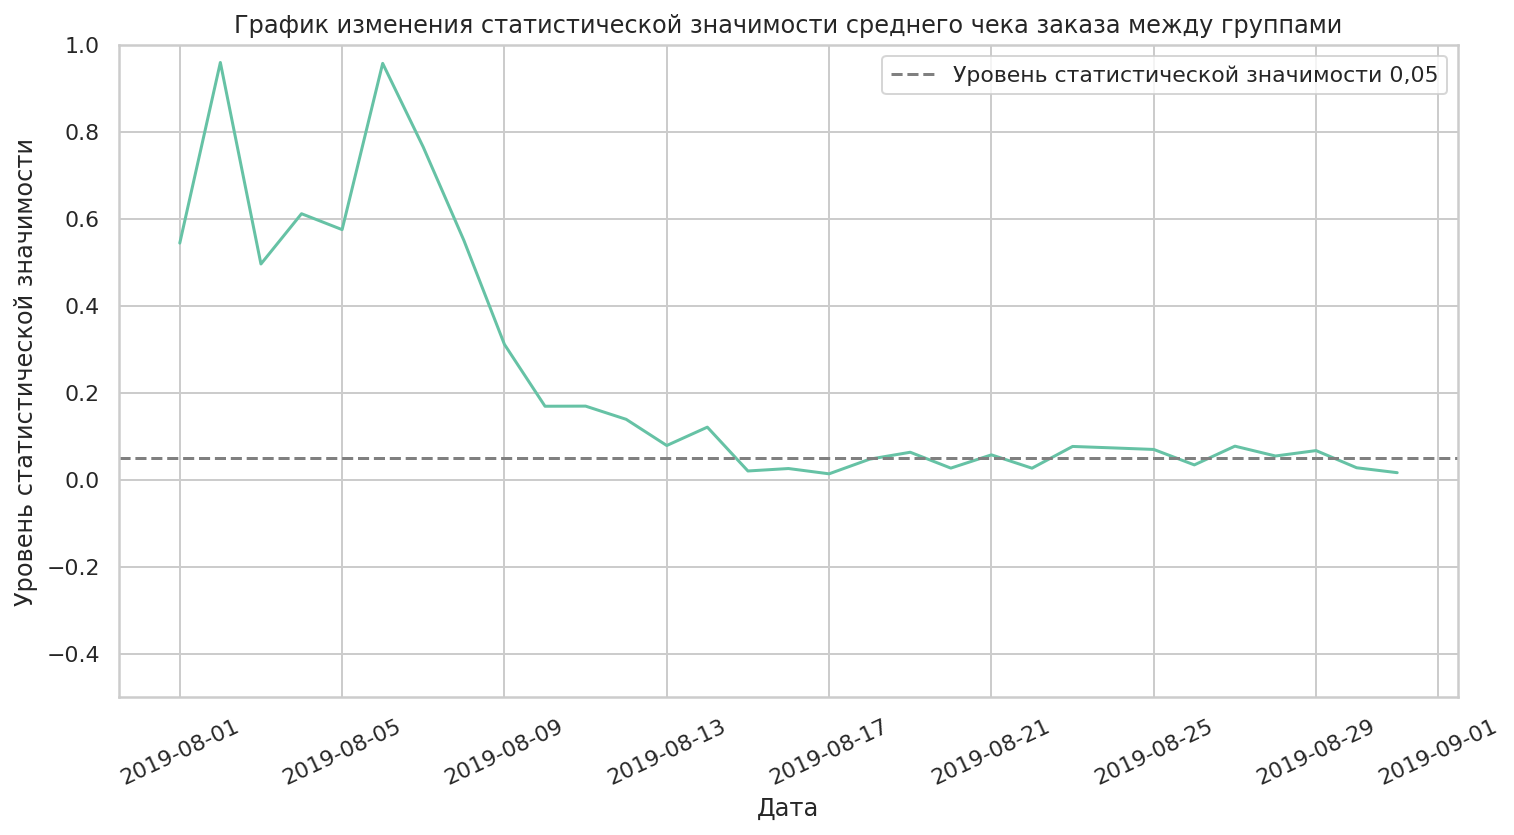

In [36]:
# посмотрим, как изменялась статистическая значимость во время проведения теста

plt.plot(revenue_mean_p_value.groupby('date')['pvalue'].mean())
plt.title('График изменения статистической значимости среднего чека заказа между группами')
plt.axhline(y=0.05, color='grey', linestyle='--', label='Уровень статистической значимости 0,05')
plt.ylabel('Уровень статистической значимости')
plt.xlabel('Дата')
plt.xticks(rotation=25)
plt.ylim(-0.5, 1)
plt.legend()
plt.show()

Статистическая значимость стабилизировалась через 2 недели на уровне 0,05 после начала теста.

На основе накопленных 37,7 тыс. наблюдений о посетителях и стабильности уровня статистической значимости делаем вывод, что тест нужно остановить и зафиксировать различия между группами: В имеет лучше показатели чем А.

**Выводы:**

- В исходном датасете заказов отношение среднего количества заказов на посетителя группы B к группе A: 14,9%, нулевая гипотеза отклоняется на уровне p-значение 0,05. В отфильтрованном датасете разница среднего количества заказов увеличилась: 16,5%, нулевая гипотеза также не принимается на уровне p-значения 0,05.

- В исходном датасете заказов отношение среднего чека заказа группы B к группе A 43,3%. Нулевую гипотезу отклоняем на уровне p-значения 0,05. Однако в отфильтрованном датасете отношение среднего чека заказа группы B к группе A всего 13%. Нулевую гипотезу также отклоняем при p-значении равном 0,05.
 
- На основе накопленных 37,7 тыс. наблюдений о посетителях и стабильности уровня статистической значимости за последние 2 недели проведения исследования делаем вывод, что тест нужно остановить и зафиксировать различия: группа В имеет лучше показатели чем А.

<a id="summary"></a>

## Выводы по исследованию

**Предобработка данных:**
- существенных различий по количеству наблюдений между группами нет,
- привели данные нужному типу,
- переименовали столбцы согласно змеинному регистру.

**Приоритизация гипотез:** 
- На основе оценки RICE в первую очередь нужно проверить гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

- На основе оценки ICE в первую очередь нужно проверить гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

**Анализ A/B-теста:**
- Выручка в обеих группах растет паралелльно. Однако в группе В есть выбросы 19 августа, из-за чего график аккумулятивной вырочки резко вырос.
- В группе А в первую неделю было много бюджетных заказов. На третью неделю средний чек по группам приходит к стабильному показателю, но из-за выбросов 19 августа в группе В наблюдаем сильно смещение вверх. Со временем данный скачок графика сглаживается. Ожидаемая сумма среднего чека ожидается в диапозоне 7000-8000.
- Группа В лучше по среднему чеку на 25% чем группа А.
- Больше заказов на пользователя в группе В - в среднем 0,034, тогда как в группе А - в среднем 0,03.
- Группа В лучше на 10% по среднему количеству заказов на пользователя чем группа А.


- **Определение значения порога для выбросов**
    - Абсолютное большинство пользователей совершили один заказ, 5% пользователей сделали 2 и более заказов, 1% пользователей - 4 и более заказов. Поэтому отфильтровали данные по 99-му перцентилю - более 4 заказов.
    - 95% заказов имеют чек до 28 тыс. Для 1% заказов стоимость составила 58,2 тыс. В данных также есть выброс - 1,3 млн., который сильно влияет на показатели метрик и результаты тестирования. Поэтому отфильтровали данные по 99-му перцентилю - более 58,2 тыс. 
    - При фильровании данных было отсечено не более 7,8% наблюдений.


- **Проверка гипотез**
    - В исходном датасете заказов отношение среднего количества заказов на посетителя группы B к группе A: 14,9%, нулевая гипотеза отклоняется на уровне p-значение 0,05. В отфильтрованном датасете разница среднего количества заказов увеличилась: 16,5%, нулевая гипотеза также не принимается на уровне p-значения 0,05.

    - В исходном датасете заказов отношение среднего чека заказа группы B к группе A 43,3%. Нулевую гипотезу отклоняем на уровне p-значения 0,05. Однако в отфильтрованном датасете отношение среднего чека заказа группы B к группе A всего 13%. Нулевую гипотезу также отклоняем при p-значении равном 0,05.

    - Статистическая значимость стабилизировалась через 2 недели на уровне 0,05 после начала теста. На основе результата статистического анализа и проверки гипотез с помощью критерия Манна-Утни, делаем вывод, что тест нужно остановить и зафиксировать различия между группами: группа В имеет лучше показатели чем А.